In [12]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentdir = os.path.abspath(os.path.join('..'))
srcdir = os.path.join(parentdir, "src")
sys.path.insert(0, parentdir) 
sys.path.insert(0, srcdir)

In [49]:
from src.data import Data
from src.data.get_fingerprints import get_np_array_of_fps
from src.data.save_predictions import save_prediction
from src.utils.const import TEST_FILE,TRAIN_FILE, FINGERPRINTS_METHODS, SMILES_COLUMN, FingerprintsNames
from typing import Optional
from xgboost import XGBClassifier
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [22]:
def _load_model(path: str):
    if not os.path.exists(path):
        raise Exception(f"No such file: {path}")

    model = XGBClassifier()
    model.load_model(path)
    return model


def _get_fingerprints(data: Data, type_name: str):
    if not (type_name in FingerprintsNames._member_names_):
        raise Exception(
            f"No such fingerprint method: {type_name}\n"
            f"Available methods:\n{FingerprintsNames._member_names_}"
        )

    method = FINGERPRINTS_METHODS[FingerprintsNames[type_name]]
    smiles, _ = data.get_processed_smiles_and_targets()

    test_fps = get_np_array_of_fps(fp_type=method, smiles=smiles)
    return test_fps


In [57]:
train_data = Data(filename=TRAIN_FILE)
train_fp = _get_fingerprints(train_data, 'MACCS')

In [58]:
train_fp = train_fp[:, 1:]

In [89]:
ts = PCA(n_components=2, random_state=0)#your_code
train_fp_reduced = ts.fit_transform(train_fp)#your_code
y = train_data.targets#your_code

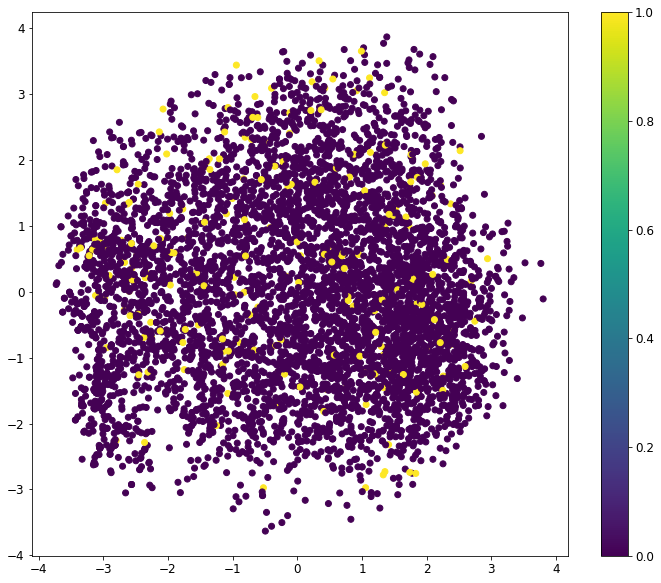

In [90]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = 12
plt.scatter(train_fp_reduced[:, 0], train_fp_reduced[:, 1], c=y, marker='o')
plt.colorbar()
plt.show()

In [24]:
model = _load_model("../models/MACCSkeys_xgboost_score_0_4731")

test_data = Data(filename=TEST_FILE)
test_fp = _get_fingerprints(test_data, 'MACCS')

test_predictions = model.predict(test_fp)



In [92]:
model.feature_importances_

array([0.        , 0.        , 0.        , 0.00645949, 0.        ,
       0.        , 0.        , 0.        , 0.0091565 , 0.        ,
       0.00060155, 0.00575025, 0.00274647, 0.0025449 , 0.0042794 ,
       0.0033652 , 0.00293603, 0.00354693, 0.        , 0.00631791,
       0.        , 0.01118512, 0.0040636 , 0.00497769, 0.00577997,
       0.00361354, 0.00250715, 0.00734268, 0.00772693, 0.01135492,
       0.00859049, 0.        , 0.00331642, 0.00775208, 0.00692939,
       0.00105128, 0.00500429, 0.00500925, 0.00351555, 0.00798597,
       0.0086062 , 0.00644428, 0.00574223, 0.00478237, 0.00355974,
       0.00661332, 0.00565356, 0.01079104, 0.0061562 , 0.0064781 ,
       0.00260251, 0.00587214, 0.00422047, 0.00428177, 0.00389815,
       0.01440752, 0.00286548, 0.00569945, 0.01183123, 0.01309304,
       0.00510283, 0.00297138, 0.00404543, 0.01081565, 0.00672359,
       0.00520872, 0.00794984, 0.00643876, 0.00230628, 0.00531313,
       0.00581356, 0.00310294, 0.00571495, 0.00719024, 0.00429

In [93]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:15]

In [61]:
MACCS_keys = {
  1:('?',0), # ISOTOPE
  #2:('[#104,#105,#106,#107,#106,#109,#110,#111,#112]',0),  # atomic num >103 Not complete
  2:('[#104]',0),  # limit the above def'n since the RDKit only accepts up to #104
  3:('[#32,#33,#34,#50,#51,#52,#82,#83,#84]',0), # Group IVa,Va,VIa Rows 4-6 
  4:('[Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr]',0), # actinide
  5:('[Sc,Ti,Y,Zr,Hf]',0), # Group IIIB,IVB (Sc...)  
  6:('[La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu]',0), # Lanthanide
  7:('[V,Cr,Mn,Nb,Mo,Tc,Ta,W,Re]',0), # Group VB,VIB,VIIB
  8:('[!#6;!#1]1~*~*~*~1',0), # QAAA@1
  9:('[Fe,Co,Ni,Ru,Rh,Pd,Os,Ir,Pt]',0), # Group VIII (Fe...)
  10:('[Be,Mg,Ca,Sr,Ba,Ra]',0), # Group IIa (Alkaline earth)
  11:('*1~*~*~*~1',0), # 4M Ring
  12:('[Cu,Zn,Ag,Cd,Au,Hg]',0), # Group IB,IIB (Cu..)
  13:('[#8]~[#7](~[#6])~[#6]',0), # ON(C)C
  14:('[#16]-[#16]',0), # S-S
  15:('[#8]~[#6](~[#8])~[#8]',0), # OC(O)O
  16:('[!#6;!#1]1~*~*~1',0), # QAA@1
  17:('[#6]#[#6]',0), #CTC
  18:('[#5,#13,#31,#49,#81]',0), # Group IIIA (B...) 
  19:('*1~*~*~*~*~*~*~1',0), # 7M Ring
  20:('[#14]',0), #Si
  21:('[#6]=[#6](~[!#6;!#1])~[!#6;!#1]',0), # C=C(Q)Q
  22:('*1~*~*~1',0), # 3M Ring
  23:('[#7]~[#6](~[#8])~[#8]',0), # NC(O)O
  24:('[#7]-[#8]',0), # N-O
  25:('[#7]~[#6](~[#7])~[#7]',0), # NC(N)N
  26:('[#6]=;@[#6](@*)@*',0), # C$=C($A)$A
  27:('[I]',0), # I
  28:('[!#6;!#1]~[CH2]~[!#6;!#1]',0), # QCH2Q
  29:('[#15]',0),# P
  30:('[#6]~[!#6;!#1](~[#6])(~[#6])~*',0), # CQ(C)(C)A
  31:('[!#6;!#1]~[F,Cl,Br,I]',0), # QX
  32:('[#6]~[#16]~[#7]',0), # CSN
  33:('[#7]~[#16]',0), # NS
  34:('[CH2]=*',0), # CH2=A
  35:('[Li,Na,K,Rb,Cs,Fr]',0), # Group IA (Alkali Metal)
  36:('[#16R]',0), # S Heterocycle
  37:('[#7]~[#6](~[#8])~[#7]',0), # NC(O)N
  38:('[#7]~[#6](~[#6])~[#7]',0), # NC(C)N
  39:('[#8]~[#16](~[#8])~[#8]',0), # OS(O)O
  40:('[#16]-[#8]',0), # S-O
  41:('[#6]#[#7]',0), # CTN
  42:('F',0), # F
  43:('[!#6;!#1;!H0]~*~[!#6;!#1;!H0]',0), # QHAQH
  44:('?',0), # OTHER
  45:('[#6]=[#6]~[#7]',0), # C=CN
  46:('Br',0), # BR
  47:('[#16]~*~[#7]',0), # SAN
  48:('[#8]~[!#6;!#1](~[#8])(~[#8])',0), # OQ(O)O
  49:('[!+0]',0), # CHARGE  
  50:('[#6]=[#6](~[#6])~[#6]',0), # C=C(C)C
  51:('[#6]~[#16]~[#8]',0), # CSO
  52:('[#7]~[#7]',0), # NN
  53:('[!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0]',0), # QHAAAQH
  54:('[!#6;!#1;!H0]~*~*~[!#6;!#1;!H0]',0), # QHAAQH
  55:('[#8]~[#16]~[#8]',0), #OSO
  56:('[#8]~[#7](~[#8])~[#6]',0), # ON(O)C
  57:('[#8R]',0), # O Heterocycle
  58:('[!#6;!#1]~[#16]~[!#6;!#1]',0), # QSQ
  59:('[#16]!:*:*',0), # Snot%A%A
  60:('[#16]=[#8]',0), # S=O
  61:('*~[#16](~*)~*',0), # AS(A)A
  62:('*@*!@*@*',0), # A$!A$A
  63:('[#7]=[#8]',0), # N=O
  64:('*@*!@[#16]',0), # A$A!S
  65:('c:n',0), # C%N
  66:('[#6]~[#6](~[#6])(~[#6])~*',0), # CC(C)(C)A
  67:('[!#6;!#1]~[#16]',0), # QS
  68:('[!#6;!#1;!H0]~[!#6;!#1;!H0]',0), # QHQH (&...) SPEC Incomplete
  69:('[!#6;!#1]~[!#6;!#1;!H0]',0), # QQH
  70:('[!#6;!#1]~[#7]~[!#6;!#1]',0), # QNQ
  71:('[#7]~[#8]',0), # NO
  72:('[#8]~*~*~[#8]',0), # OAAO
  73:('[#16]=*',0), # S=A
  74:('[CH3]~*~[CH3]',0), # CH3ACH3
  75:('*!@[#7]@*',0), # A!N$A
  76:('[#6]=[#6](~*)~*',0), # C=C(A)A
  77:('[#7]~*~[#7]',0), # NAN
  78:('[#6]=[#7]',0), # C=N
  79:('[#7]~*~*~[#7]',0), # NAAN
  80:('[#7]~*~*~*~[#7]',0), # NAAAN
  81:('[#16]~*(~*)~*',0), # SA(A)A
  82:('*~[CH2]~[!#6;!#1;!H0]',0), # ACH2QH
  83:('[!#6;!#1]1~*~*~*~*~1',0), # QAAAA@1
  84:('[NH2]',0), #NH2
  85:('[#6]~[#7](~[#6])~[#6]',0), # CN(C)C
  86:('[C;H2,H3][!#6;!#1][C;H2,H3]',0), # CH2QCH2
  87:('[F,Cl,Br,I]!@*@*',0), # X!A$A
  88:('[#16]',0), # S
  89:('[#8]~*~*~*~[#8]',0), # OAAAO
  90:('[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R]1@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~[R]1@[R]@[CH2;R]1)]',0), # QHAACH2A
  91:('[$([!#6;!#1;!H0]~*~*~*~[CH2]~*),$([!#6;!#1;!H0;R]1@[R]@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~[R]1@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~*~[R]1@[R]@[CH2;R]1)]',0), # QHAAACH2A
  92:('[#8]~[#6](~[#7])~[#6]',0), # OC(N)C
  93:('[!#6;!#1]~[CH3]',0), # QCH3
  94:('[!#6;!#1]~[#7]',0), # QN
  95:('[#7]~*~*~[#8]',0), # NAAO
  96:('*1~*~*~*~*~1',0), # 5 M ring
  97:('[#7]~*~*~*~[#8]',0), # NAAAO
  98:('[!#6;!#1]1~*~*~*~*~*~1',0), # QAAAAA@1
  99:('[#6]=[#6]',0), # C=C
  100:('*~[CH2]~[#7]',0), # ACH2N
  101:('[$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1)]',0), # 8M Ring or larger. This only handles up to ring sizes of 14
  102:('[!#6;!#1]~[#8]',0), # QO
  103:('Cl',0), # CL
  104:('[!#6;!#1;!H0]~*~[CH2]~*',0), # QHACH2A
  105:('*@*(@*)@*',0), # A$A($A)$A
  106:('[!#6;!#1]~*(~[!#6;!#1])~[!#6;!#1]',0), # QA(Q)Q
  107:('[F,Cl,Br,I]~*(~*)~*',0), # XA(A)A
  108:('[CH3]~*~*~*~[CH2]~*',0), # CH3AAACH2A
  109:('*~[CH2]~[#8]',0), # ACH2O
  110:('[#7]~[#6]~[#8]',0), # NCO
  111:('[#7]~*~[CH2]~*',0), # NACH2A
  112:('*~*(~*)(~*)~*',0), # AA(A)(A)A
  113:('[#8]!:*:*',0), # Onot%A%A
  114:('[CH3]~[CH2]~*',0), # CH3CH2A
  115:('[CH3]~*~[CH2]~*',0), # CH3ACH2A
  116:('[$([CH3]~*~*~[CH2]~*),$([CH3]~*1~*~[CH2]1)]',0), # CH3AACH2A
  117:('[#7]~*~[#8]',0), # NAO
  118:('[$(*~[CH2]~[CH2]~*),$(*1~[CH2]~[CH2]1)]',1), # ACH2CH2A > 1
  119:('[#7]=*',0), # N=A
  120:('[!#6;R]',1), # Heterocyclic atom > 1 (&...) Spec Incomplete
  121:('[#7;R]',0), # N Heterocycle
  122:('*~[#7](~*)~*',0), # AN(A)A
  123:('[#8]~[#6]~[#8]',0), # OCO
  124:('[!#6;!#1]~[!#6;!#1]',0), # QQ
  125:('?',0), # Aromatic Ring > 1
  126:('*!@[#8]!@*',0), # A!O!A
  127:('*@*!@[#8]',1), # A$A!O > 1 (&...) Spec Incomplete
  128:('[$(*~[CH2]~*~*~*~[CH2]~*),$([R]1@[CH2;R]@[R]@[R]@[R]@[CH2;R]1),$(*~[CH2]~[R]1@[R]@[R]@[CH2;R]1),$(*~[CH2]~*~[R]1@[R]@[CH2;R]1)]',0), # ACH2AAACH2A
  129:('[$(*~[CH2]~*~*~[CH2]~*),$([R]1@[CH2]@[R]@[R]@[CH2;R]1),$(*~[CH2]~[R]1@[R]@[CH2;R]1)]',0), # ACH2AACH2A
  130:('[!#6;!#1]~[!#6;!#1]',1), # QQ > 1 (&...)  Spec Incomplete
  131:('[!#6;!#1;!H0]',1), # QH > 1
  132:('[#8]~*~[CH2]~*',0), # OACH2A
  133:('*@*!@[#7]',0), # A$A!N
  134:('[F,Cl,Br,I]',0), # X (HALOGEN)
  135:('[#7]!:*:*',0), # Nnot%A%A
  136:('[#8]=*',1), # O=A>1 
  137:('[!C;!c;R]',0), # Heterocycle
  138:('[!#6;!#1]~[CH2]~*',1), # QCH2A>1 (&...) Spec Incomplete
  139:('[O;!H0]',0), # OH
  140:('[#8]',3), # O > 3 (&...) Spec Incomplete
  141:('[CH3]',2), # CH3 > 2  (&...) Spec Incomplete
  142:('[#7]',1), # N > 1
  143:('*@*!@[#8]',0), # A$A!O
  144:('*!:*:*!:*',0), # Anot%A%Anot%A
  145:('*1~*~*~*~*~*~1',1), # 6M ring > 1
  146:('[#8]',2), # O > 2
  147:('[$(*~[CH2]~[CH2]~*),$([R]1@[CH2;R]@[CH2;R]1)]',0), # ACH2CH2A
  148:('*~[!#6;!#1](~*)~*',0), # AQ(A)A
  149:('[C;H3,H4]',1), # CH3 > 1
  150:('*!@*@*!@*',0), # A!A$A!A
  151:('[#7;!H0]',0), # NH
  152:('[#8]~[#6](~[#6])~[#6]',0), # OC(C)C
  153:('[!#6;!#1]~[CH2]~*',0), # QCH2A
  154:('[#6]=[#8]',0), # C=O
  155:('*!@[CH2]!@*',0), # A!CH2!A
  156:('[#7]~*(~*)~*',0), # NA(A)A
  157:('[#6]-[#8]',0), # C-O
  158:('[#6]-[#7]',0), # C-N
  159:('[#8]',1), # O>1
  160:('[C;H3,H4]',0), #CH3
  161:('[#7]',0), # N
  162:('a',0), # Aromatic
  163:('*1~*~*~*~*~*~1',0), # 6M Ring
  164:('[#8]',0), # O
  165:('[R]',0), # Ring
  166:('?',0), # Fragments  FIX: this can't be done in SMARTS
  }

In [77]:
MACCS_names = np.array([MACCS_keys[i][0] for i in range(1, 167)])

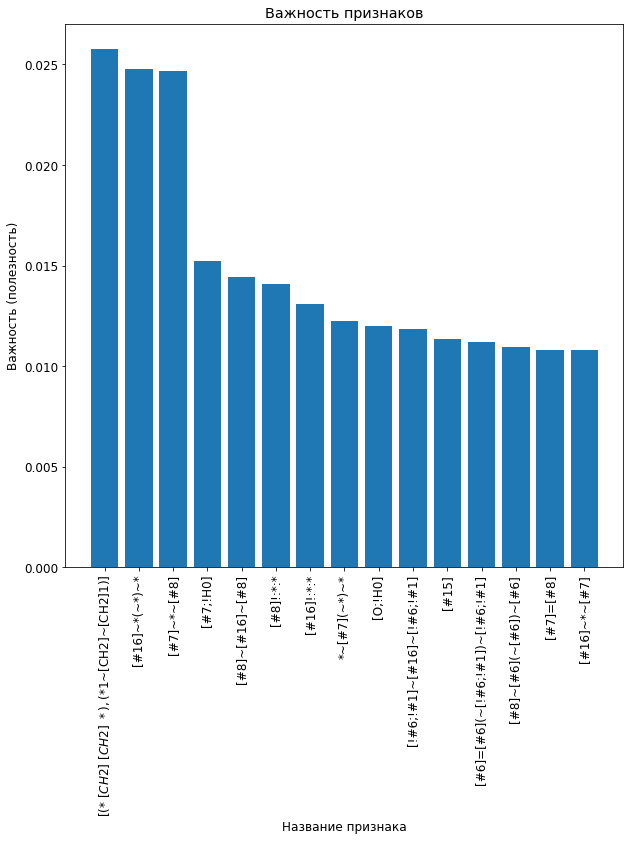

In [86]:
plt.figure(figsize=(10, 10))

plt.title('Важность признаков')
plt.ylabel('Важность (полезность)')
plt.xlabel('Название признака')

plt.bar(list(range(len(indices))), importances[indices])
plt.xticks(range(len(indices)),MACCS_names[indices],rotation=90)
plt.show()

In [88]:
MACCS_names[indices][:3]

array(['[$(*~[CH2]~[CH2]~*),$(*1~[CH2]~[CH2]1)]', '[#16]~*(~*)~*',
       '[#7]~*~[#8]'], dtype='<U351')

In [94]:
indices

array([118,  81, 117, 151,  55, 113,  59, 122, 139,  58,  29,  21, 152,
        63,  47], dtype=int64)